# Проект: Статистический анализ данных

# Анализ данных и проверка гипотез сервиса аренды самокатов GoFast

У нас есть данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо их проанализировать и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Цель исследования:**
1. Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.
2. Провести подсчет помесячной выручки, которую принёс каждый пользователь. 
3. Проверить гипотезы, которые помогут увеличить количество пользователей с подпиской.
4. Построить распределения, которые помогут ответить на вопросы отдела маркетинга о рассылке промокодов и push-уведомлениях.

**Ход исследования**

Данные получим из файлов `'users_go.csv', rides_go.csv, subscriptions_go.csv` , просмотрим общую информацию о датасете, оценим качество данных.

Далее приступим к предобработке данных: проверим и исправим ошибки, которые не приведут к искажению конечного результата, оценим их влияние на исследование. Также создадим необходимые столбцы, которые помогут в дальнейшем исследовании.

Затем настанет очередь исследовательского анализа данных.

Завершающим этапом исследования будет проверка гипотез и построение графика распределения.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Предобработка данных](#preprocessing)

- [Добавление новых столбцов](#new_columns)

- [Исследовательский анализ данных: обработка аномальных значений, исследование данных о пользователях с подпиской и без, влияния на выручку](#EDA)
- [Проверка гипотез](#hypothesis)

- [Распределения](#func)

- [Общий вывод](#final)

## Описание данных

**Пользователи** — `users_go.csv`

| | |
| ------ | ------ | 
| **user_id** | уникальный идентификатор пользователя | 
| **name** | имя пользователя |
| **age** | возраст |
| **city** | город |
| **subscription_type** | тип подписки (free, ultra)|

______________________________________
**Поездки** — `rides_go.csv`

| | |
| ------ | ------ | 
| **user_id** | уникальный идентификатор пользователя | 
| **distance** | расстояние, которое пользователь проехал в текущей сессии (в метрах) |
| **duration** | продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» |
| **date** | дата совершения поездки |

______________________________________
**Подписки** — `subscriptions_go.csv`

| | |
| ------ | ------ | 
| **subscription_type** | тип подписки | 
| **minute_price** | стоимость одной минуты поездки по данной подписке |
| **start_ride_price** | стоимость начала поездки |
| **subscription_fee** | стоимость ежемесячного платежа |



### **Общая информация**
<a id='info'></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import binom
import math
from math import factorial
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [19]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv', dayfirst=True)
subscriptions = pd.read_csv('subscriptions_go.csv')

In [13]:
# Выведем первые 5 строк таблицы пользователей
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [20]:
# Выведем первые 5 строк таблицы поездок
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [15]:
# Выведем первые строки таблицы подписок
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [16]:
# Общая информация о таблице users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [21]:
# Общая информация о таблице rides
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [18]:
# Общая информация о таблице subscriptions
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


_________________________________
В датафрейме с **пользователями** всего 1565 строк и 5 столбцов.

В датафрейме с **поездками** всего 18968 строк и 4 столбца.

В датафрейме с **подписками** всего 2 строки и 4 столбца.

### **Предобработка данных**
<a id='preprocessing'></a>

#### **Изменение типов данных, где необходимо**

Приведем столбец `date` к типу даты pandas.

In [22]:
rides['date'] = pd.to_datetime(rides['date'])

#### **Создание новых столбцов**
<a id='new_columns'></a>

Создаем новый столбец с номером месяца на основе столбца `date`.

In [23]:
rides['month'] = rides['date'].dt.month

#### **Пропущенные значения**

Определим, в каких столбцах есть пропуски.

In [24]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [25]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [26]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Данные собраны довольно качественно, в них отсутствуют пропущенные значения.

#### **Явные и неявные дубликаты**

Проверим количество **явных** дубликатов в данных.

In [27]:
users.duplicated().sum()

31

In [28]:
rides.duplicated().sum()

0

In [29]:
subscriptions.duplicated().sum()

0

В таблице пользователей присутствуют явные дубликаты, удалим их.

In [30]:
users = users.drop_duplicates()

Проверим количество **неявных** дубликатов в данных.

In [31]:
sorted(users['city'].unique())

['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

Таким образом, неявные дубликаты не обнаружены. 

#### **За какой период данные**

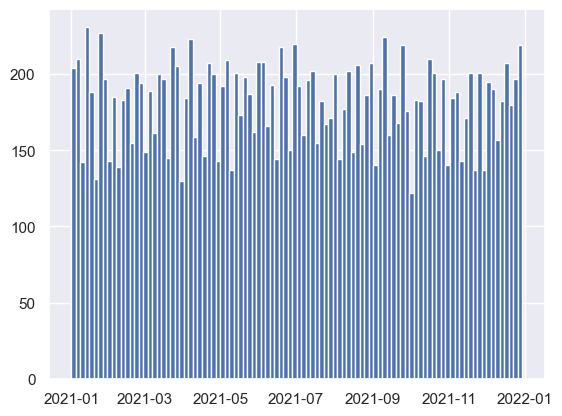

In [32]:
# Строим гистограмму столбца 'date'
rides['date'].hist(bins=100);

Данные представлены за год: с 2021 по 2022, они не склеятся при агрегации по месяцам.

**Вывод:** данные за год собраны качественно, пропущенных значений и неявных дубликатов нет, явные дубликаты были найдены и удалены. 

### **Исследовательский анализ данных**
<a id='EDA'></a>

Опишем и визуализируем общую информацию о пользователях и поездках

In [33]:
# Напишем функцию для визуализации параметров
def hist_plot(data, column, bins, title, xlabel):
    data[column].hist(bins=bins, figsize=(12,5))
    plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество значений')

#### **Частота встречаемости городов**

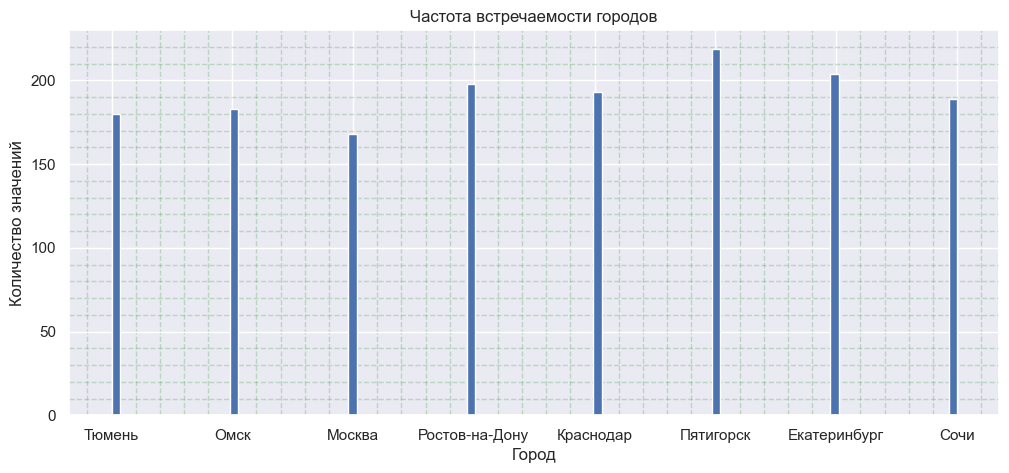

In [34]:
# Строим гистограмму для столбца 'city'
hist_plot(users, 'city', 100, 'Частота встречаемости городов', 'Город')

In [35]:
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

In [36]:
# Выведем  таблицу с числовыми значениями частотности городов и среднее
cities = pd.DataFrame(users['city'].value_counts()).rename(columns={'city':'Количество пользователей'})
print('Среднее', cities.mean())
cities

Среднее count    191.75
dtype: float64


,count
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Количество пользователей на город распределено достаточно равномерно, выдающихся значений нет. Частота встречаемости городов варьируется в диапазоне от 170 до 220, среднее значение 191.75, самый популярный город - Пятигорск.

#### **Соотношение пользователей с подпиской и без подписки**

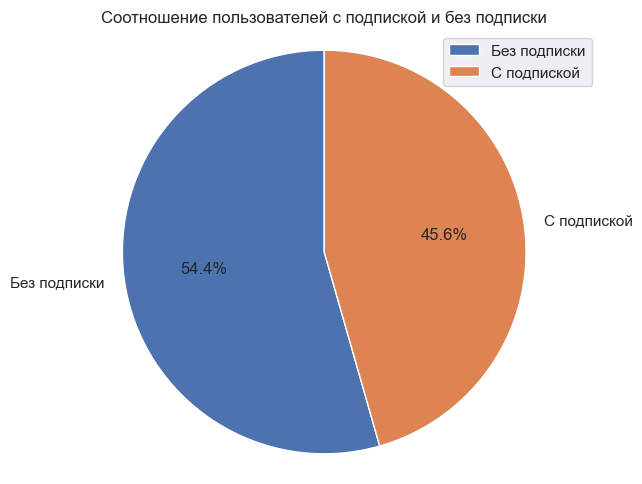

In [43]:
# Создадим датафрейм с количеством пользователей в каждой категории
subs = pd.DataFrame({'Количество пользователей': users['subscription_type'].value_counts()})
# Построим круговую диаграмму для столбца 'subscription_type'
patches, texts, autotexts = plt.pie(subs['Количество пользователей'], labels=['Без подписки','С подпиской'], autopct='%1.1f%%', startangle=90)  
plt.legend(patches, ['Без подписки','С подпиской'], loc="best")  
plt.axis('equal')  
plt.tight_layout()  
plt.title('Соотношение пользователей с подпиской и без подписки')  
plt.show()  

In [44]:
subs

,Количество пользователей
subscription_type,
free,835
ultra,699


Пользователей без подписки больше, чем с подпиской на 8.8%.

#### **Возраст пользователей**

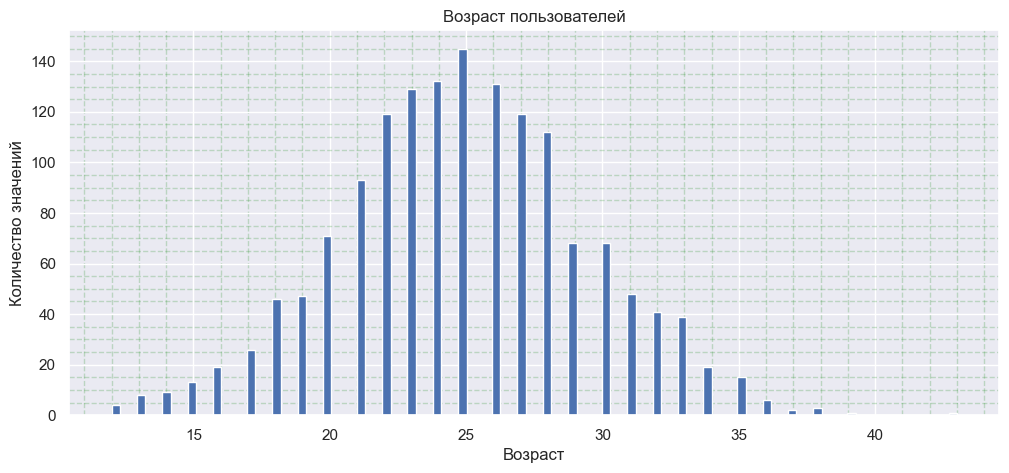

In [45]:
# Строим гистограмму для столбца 'age'
hist_plot(users, 'age', 100, 'Возраст пользователей', 'Возраст')

In [46]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Согласно правилам дорожного движения, возраст допуска к управлению маломощными средствами индивидуальной мобильности (СИМ) — 14 лет. Ограничим данные этим значением снизу.

In [47]:
users = users.drop(users[users['age'] < 14].index)

Популярный возраст пользователей варьируется от 22 до 28 лет.

#### **Расстояние, которое пользователь преодолел за одну поездку**

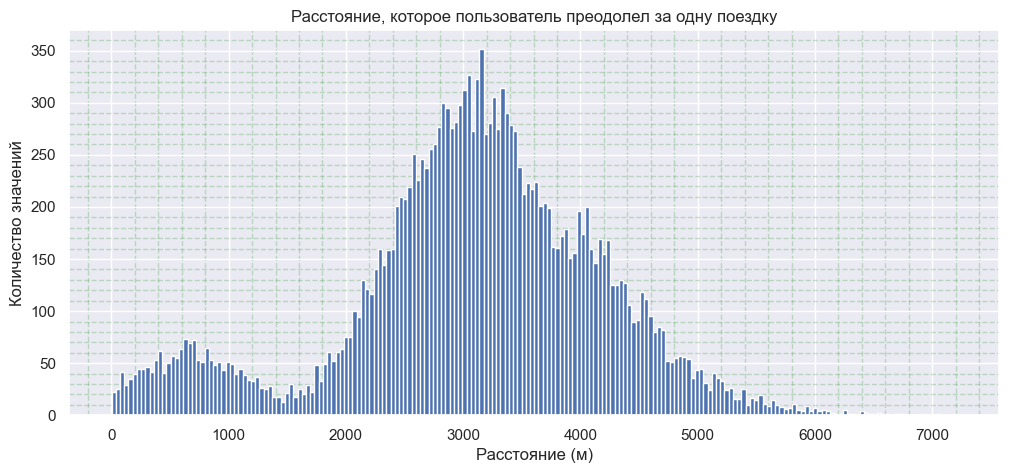

In [48]:
# Строим гистограмму для столбца 'distance'
hist_plot(rides, 'distance', 200, 'Расстояние, которое пользователь преодолел за одну поездку', 'Расстояние (м)')

In [49]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Самый популярный маршрут составляет ~ 3100м. Выдающихся и аномальных значений нет, данные соответствуют реальности.

#### **Продолжительность поездок**

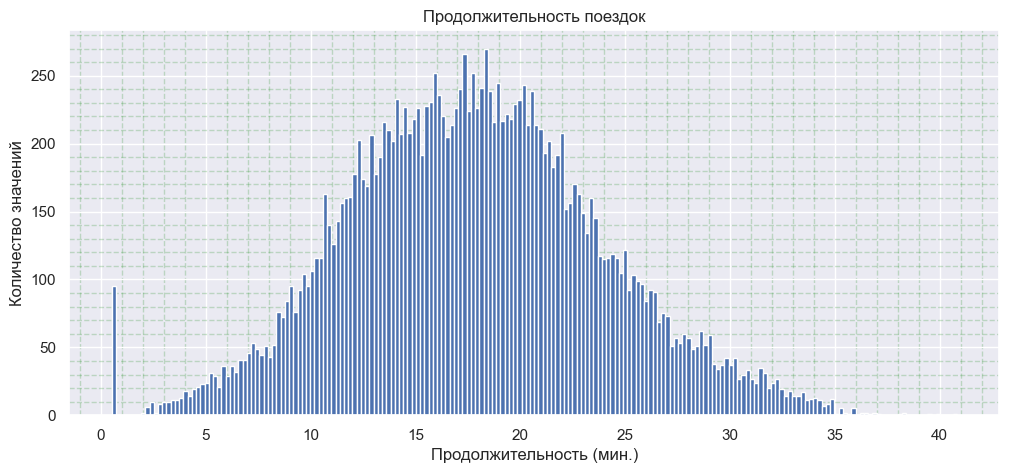

In [50]:
# Строим гистограмму для столбца 'duration'
hist_plot(rides, 'duration', 200, 'Продолжительность поездок', 'Продолжительность (мин.)')

In [51]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Данные соответствуют реальности. Средняя продолжительность поездок - 17 минут, популярное время поездки находится в пределах от 13 до 22 минут.

### **Объединение данных**

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [52]:
# Смотрим исходную размерность данных
print(len(users),len(rides),len(subscriptions))

1522 18068 2


In [53]:
all_data = rides.merge(users, on='user_id', how='left').merge(subscriptions, on='subscription_type',how='left')
all_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22.0,Тюмень,ultra,6.0,0.0,199.0
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22.0,Тюмень,ultra,6.0,0.0,199.0
2,1,754.159807,6.232113,2021-04-20,4,Кира,22.0,Тюмень,ultra,6.0,0.0,199.0
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22.0,Тюмень,ultra,6.0,0.0,199.0
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22.0,Тюмень,ultra,6.0,0.0,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25.0,Краснодар,free,8.0,50.0,0.0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25.0,Краснодар,free,8.0,50.0,0.0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25.0,Краснодар,free,8.0,50.0,0.0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25.0,Краснодар,free,8.0,50.0,0.0


Размерность таблицы, к которой присоединяли совпала с исходной.Проверим пропуски в получившемся датафрейме.

In [54]:
all_data.isna().sum()

user_id                0
distance               0
duration               0
date                   0
month                  0
name                 140
age                  140
city                 140
subscription_type    140
minute_price         140
start_ride_price     140
subscription_fee     140
dtype: int64

Пропуски присутствуют в категориальных переменных, которые невозможно заполнить. Удалим эти пропущенные значения.

In [55]:
all_data = all_data.dropna()
# Проверим, удалили ли все пропуски
all_data.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Создадим ещё два датафрейма из датафрейма выше:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [56]:
free_users = all_data.query('subscription_type == "free"')
ultra_users = all_data.query('subscription_type == "ultra"')

Визуализируем информацию о **расстоянии и времени** поездок для пользователей обеих категорий.

#### **Пользователи с подпиской**

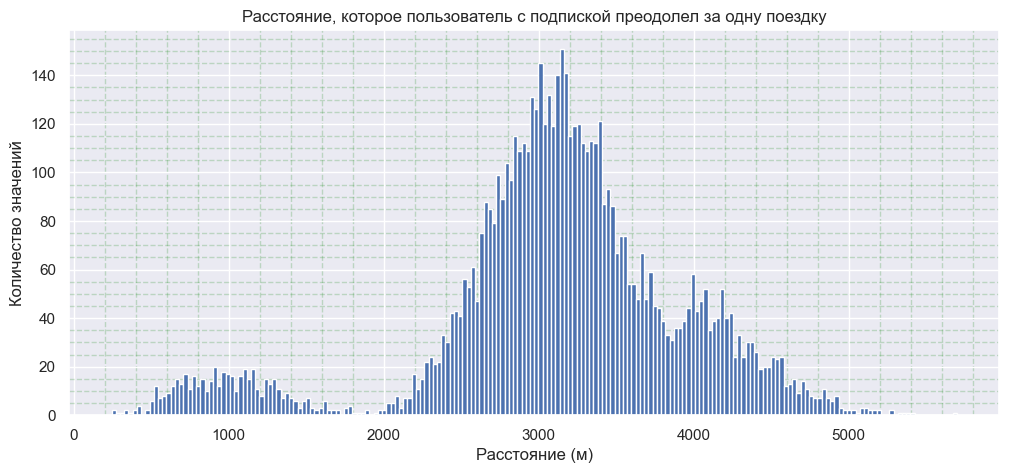

In [57]:
# Строим гистограмму для столбца 'distance'
hist_plot(ultra_users, 'distance', 200, 'Расстояние, которое пользователь с подпиской преодолел за одну поездку', 'Расстояние (м)')

In [58]:
ultra_users['distance'].describe()

count    6429.000000
mean     3113.982982
std       837.559485
min       244.210438
25%      2783.954794
50%      3147.729566
75%      3559.663262
max      5699.769662
Name: distance, dtype: float64

Пользователи с подпиской чаще выбирают дальние поездки, чем близкие. Популярные маршруты составляют от 2700 до 3500м. Среднее расстояние ~ 3100м, минимальное - 244м.

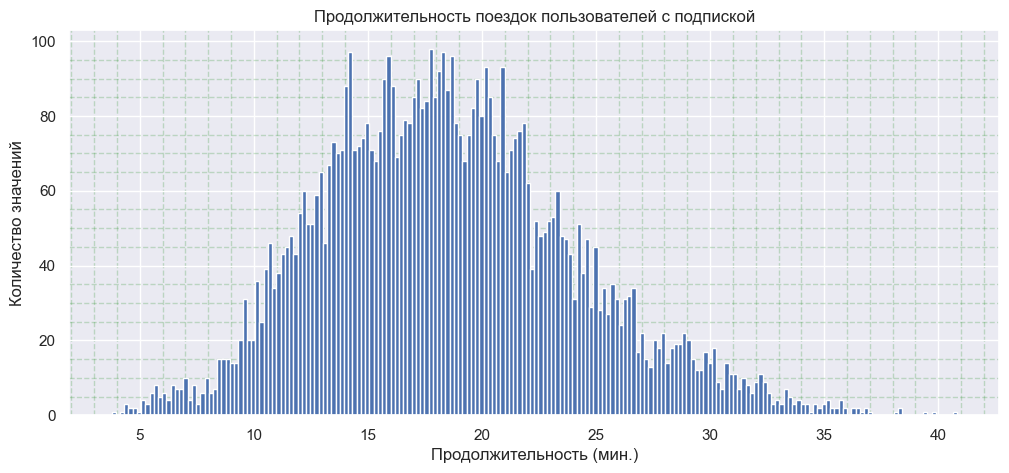

In [59]:
# Строим гистограмму для столбца 'duration'
hist_plot(ultra_users, 'duration', 200, 'Продолжительность поездок пользователей с подпиской', 'Продолжительность (мин.)')

In [60]:
ultra_users['duration'].describe()

count    6429.000000
mean       18.542236
std         5.576216
min         3.760353
25%        14.516951
50%        18.179617
75%        21.884591
max        40.823963
Name: duration, dtype: float64

Чаще всего продолжительность поездок пользователей с подпиской от 14 до 21 минуты, среднее время - 18 минут, минимальное - 3 минуты. 

#### **Пользователи без подписки**

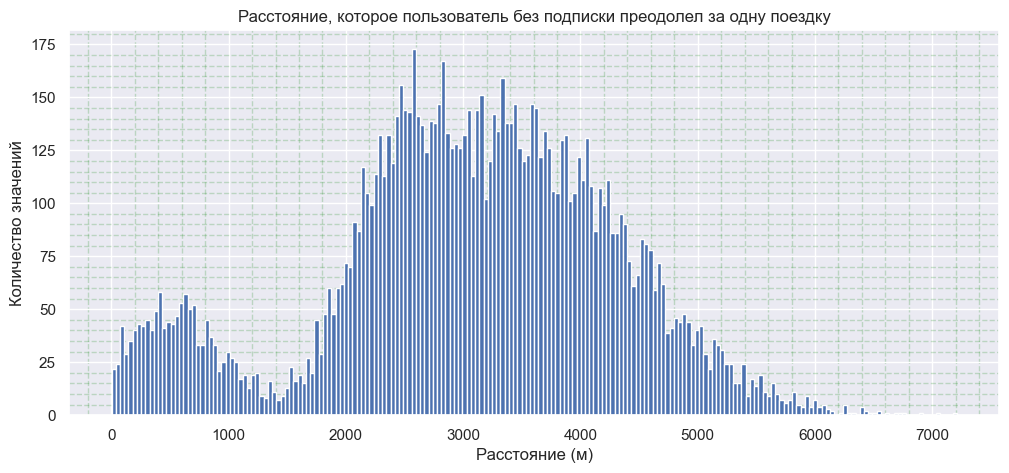

In [61]:
# Строим гистограмму для столбца 'distance'
hist_plot(free_users, 'distance', 200, 'Расстояние, которое пользователь без подписки преодолел за одну поездку', 'Расстояние (м)')

In [62]:
free_users['distance'].describe()

count    11499.000000
mean      3044.786901
std       1246.500072
min          0.855683
25%       2365.733495
50%       3114.097211
75%       3905.145641
max       7211.007745
Name: distance, dtype: float64

Пользователи без подписки чаще всего выбирают маршрут от 2300 до 3800м, минимальное расстояние - 0.8м, среднее ~ 3000м. 

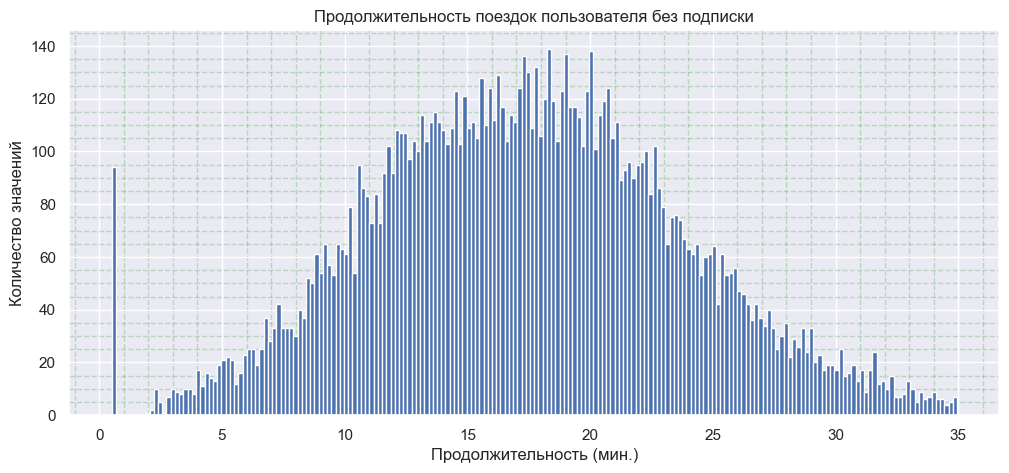

In [63]:
# Строим гистограмму для столбца 'duration'
hist_plot(free_users, 'duration', 200, 'Продолжительность поездок пользователя без подписки', 'Продолжительность (мин.)')

In [64]:
free_users['duration'].describe()

count    11499.000000
mean        17.385354
std          6.324565
min          0.500000
25%         12.954778
50%         17.326291
75%         21.589807
max         34.948498
Name: duration, dtype: float64

Чаще всего пользователи без подписки совершают поездки от 13 до 21 минуты, среднее время ~ 17 минут, минимальное - 2 минуты.

**Вывод:** пользователи с подпиской чаще ездят на более дальние расстояния, так как график расстояний имеет меньший разброс вокруг среднего - 3100м. Популярная продолжительность поездок у обоих категорий пользователей примерно в одном диапазоне - от 13 до 21 минуты.

### **Подсчёт выручки**

Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [65]:
# Округлим продолжительность каждой поездки до следующего целого числа 
all_data.loc[:, 'duration'] = np.ceil(all_data.loc[:, 'duration'])

In [66]:
gain = all_data.groupby(['user_id','month']).agg(
    total_distance=('distance', 'sum'),
    total_rides=('distance', 'count'), 
    total_duration=('duration', 'sum')).reset_index()
gain.head(10)

,user_id,month,total_distance,total_rides,total_duration
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0
5,1,12,6751.629942,2,28.0
6,2,3,10187.723006,3,63.0
7,2,4,6164.381824,2,40.0
8,2,6,3255.338202,1,14.0
9,2,7,6780.722964,2,48.0


Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [67]:
# Создаем множество ultra_users_ids для эффективного поиска
ultra_users_ids = set(ultra_users['user_id'])
# Подсчитаем месячную выручку для каждого пользователя
gain['monthly_gain'] = gain.apply(lambda row: 6 * row['total_duration'] + 199 
                                  if row['user_id'] in ultra_users_ids 
                                  else 50 * row['total_rides'] + 8 * row['total_duration'], 
                                  axis=1)

In [68]:
# Добавим столбец с типом подписки пользователя
gain['subscription_type'] = gain['user_id'].apply(lambda user_id: 'ultra' if user_id in ultra_users_ids else 'free')

In [69]:
# Изменим тип данных 'total_duration' и 'monthly_gain' на целочисленный, так как у них нулевая дробная часть
gain = gain.astype({'total_duration':'int', 'monthly_gain': 'int'},errors='ignore')
gain.head(10)

,user_id,month,total_distance,total_rides,total_duration,monthly_gain,subscription_type
0,1,1,7027.511294,2,42,451,ultra
1,1,4,754.159807,1,7,241,ultra
2,1,8,6723.470560,2,46,475,ultra
3,1,10,5809.911100,2,32,391,ultra
4,1,11,7003.499363,3,56,535,ultra
5,1,12,6751.629942,2,28,367,ultra
6,2,3,10187.723006,3,63,577,ultra
7,2,4,6164.381824,2,40,439,ultra
8,2,6,3255.338202,1,14,283,ultra
9,2,7,6780.722964,2,48,487,ultra


Таким образом, мы создали дополнительный столбец с помесячной выручкой, который поможет в дальнейшем исследовании.

### **Проверка гипотез**
<a id='hypothesis'></a>

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Нам нужно выяснить несколько важных моментов, чтобы помочь бизнесу.

#### **Тратят ли пользователи с подпиской больше времени на поездки?**
H<sub>0</sub>: Пользователи с подпиской и без в среднем тратят равное количество времени на поездки

H<sub>1</sub>: Пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки

Обе генеральные совокупности (пользователи с подпиской и без) не очень большие и помещаются в оперативную память компьютера, значит будем сравнивать их средние. Вывод о значимости этой разницы проверим с помощью статистического теста.

In [50]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ultra_users['duration'], free_users['duration'], alternative='greater')
print(f'p-значение:{results.pvalue:.4f}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: среднее время поездок пользователей с подпиской сильно превышает среднее время поездок пользователей без подписки')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение:0.0000
Отвергаем нулевую гипотезу: среднее время поездок пользователей с подпиской сильно превышает среднее время поездок пользователей без подписки


**Вывод:** Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

#### **Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**
H<sub>0</sub>: Пользователи с подпиской в среднем проезжают расстояние в 3130 метров

H<sub>1</sub>: Пользователи с подпиской в среднем проезжают расстояние больше, чем 3130 метров

In [51]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для одной выборки, в качестве альтернативной используем одностороннюю гипотезу «меньше»
results = st.ttest_1samp(ultra_users['distance'], popmean=3130, alternative='greater')
print(f'p-значение:{results.pvalue:.4f}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: среднее расстояние сильно превышает 3130 метров')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров')

p-значение:0.9374
Нет оснований отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров


**Вывод:** Есть основания говорить, что пользователи с подпиской в среднем проезжают не больше, чем 3130 метров.

#### **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**
H<sub>0</sub>: Разница между средней помесячной выручкой от пользователей с подпиской и без по месяцам равна нулю.

H<sub>1</sub>: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки


In [52]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(gain[gain['subscription_type']=='ultra']['monthly_gain'], gain[gain['subscription_type']=='free']['monthly_gain'], alternative='greater')
print(f'p-значение:{results.pvalue:.4f}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: помесячная выручка от пользователей с подпиской по месяцам выше')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение:0.0000
Отвергаем нулевую гипотезу: помесячная выручка от пользователей с подпиской по месяцам выше


**Вывод:** Есть основания говорить, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

#### **Аналитическая задача**
Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

**Ответ:** мы измеряем количество обращений до обновления и после него - дважды для одних и тех же пользователей. Значит мы имеем дело с двумя парными выборками -  будем проверять гипотезу о равенстве среднего значения генеральной совокупности до и после изменения. Для этого нам понадобится метод `scipy.ttest_rel`, в качестве аргументов передадим данные после изменения и до, а также укажем `alternative=less`, чтобы проверить правостороннюю гипотезу о том, что значения после изменений меньше, чем до. 

### **Распределения**
<a id='func'></a>

#### Акция с раздачей промокодов
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

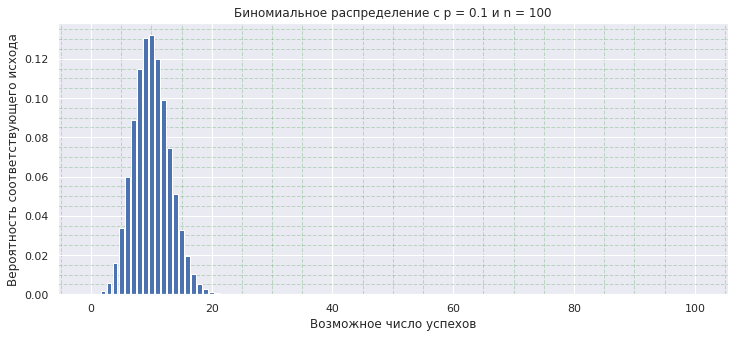

In [53]:
# Зададим биномиальное распределение с произвольным N и построим его график
n = 100 # количество попыток
p = 0.1 # вероятность успеха
distr = []
for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
plt.figure(figsize=(12,5))
plt.bar(range(0, n + 1), distr)
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.title(f'Биномиальное распределение с p = {p} и n = {n}')
plt.xlabel('Возможное число успехов')
plt.ylabel('Вероятность соответствующего исхода');

Перед нами биномиальное распределение с малым p и достаточно малым n. Наша задача - подобрать такое n, чтобы вероятность числа успехов < 100 была примерно 5%. В этом нам поможет кумулятивная функция распределения, которая на вход принимает один аргумент и возвращает вероятность, что случайная величина примет значение, меньшее заданного аргумента. В нашем случае аргументом функции будет число 100 - именно столько клиентов должно продлить подписку.

Дальнейший план действий состоит в следующем:
1. Варьировать число n
2. Оценить вероятность, что случайная величина примет значение, меньше 100 (нас устроит 5%)
3. Если вероятность не совпадет с необходимой для задачи, повторить пункты 1-2.

Судя по графику, мы можем предположить, что число n будет достаточно большим.

In [54]:
p = 0.1
n = 1170
distr = binom(n, p)
result = distr.cdf(100)
result

0.05151491673741622

**Ответ:** таким образом, минимум 1170 промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

#### Push-уведомления в мобильном приложении
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [55]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = math.sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тыс.
result = distr.cdf(399500)
result

0.15371708296369768

**Ответ:** вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 15%.

### Выводы
<a id='final'></a>

Таким образом мы провели исследование данных сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках и выполнили следующие цели:
1. Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий.
2. Провели подсчет помесячной выручки, которую принёс каждый пользователь.
3. Проверили гипотезы, которые помогут увеличить количество пользователей с подпиской.
4. Построили распределения, которые помогут ответить на вопросы отдела маркетинга о рассылке промокодов и push-уведомлениях.


Для этого были выполнены следующие действия:

- **Открыты файлы** с данными и изучена общая информация: В датафрейме с пользователями всего 1565 строк и 5 столбцов, с поездками - 18968 строк и 4 столбца, с подписками - 2 строки и 4 столбца.


- Выполнена **предобработка данных:**
    
    определили, что в данных отсутствуют пропуски; 
    
    изучили неявные дубликаты, которых не было обнаружено
    
    удалили 30 явных дубликатов.


- Провели **исследовательский анализ данных:**

  рассмотрели частоту встречаемости городов - среднее значение 191.75, самый популярный город - Пятигорск.

  определили соотношение пользователей с подпиской и без - пользователей без подписки больше на 8.8%;

  изучили возраст пользователей - сервис популярен среди молодежи от 22 до 28 лет;

  выяснили, что самый популярный маршрут составляет ~ 3100м, а средняя продолжительность поездок - 17 минут;
  

- **Изучили пользователей** в  каждой категории:пользователи с подпиской чаще ездят на более дальние расстояния, так как график расстояний имеет меньший разброс вокруг среднего - 3100м. Популярная продолжительность поездок у обоих категорий пользователей примерно в одном диапазоне - от 13 до 21 минуты.

  
- Провели **подсчет помесячной выручки** по каждой категории пользователей, чтобы проверить гипотезы


- **Проверили гипотезы** и выяснили, что:

  пользователи с подпиской тратят больше времени на поездки;

  пользователи с подпиской в среднем проезжают не больше, чем 3130 метров;

  помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
  

- **Построили распределения** и выяснили, что:

  минимум 1170 промокодов нужно разослать, чтобы вероятность не выполнить план в 100 продленных подписок была примерно 5 %;

  вероятность того, что уведомление откроют не более 399,5 тыс. пользователей из 1 млн. равна 15%.




  